In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint

# Define parameters

In [2]:
Tc = 60 #Temperature in Celsius

#mol fraction of incoming gas
y_co = 0.4 #[mol/mol]
y_co2 = 0.2 #[mol/mol]
y_h2 = 0.38 #[mol/mol]
y_o2 = 0.01 #[mol/mol]
y_n2 = 0.01 #[mol/mol]

#Universal constants:
R = 8.314 # [m^3*Pa/K/mol]

def Kelvin_Celsius(t):
    """
    This function converts Temperature values from Kelvin to degrees Celsius
    """
    return t-273.15

def Celsius_Kelvin(t):
    """
    This function converts Temperature values from degrees Celsius to Kelvin
    """
    return t+273.15

T = Celsius_Kelvin(Tc)

# Repeat Yield Calculation

In [3]:
# View 02_AcetogenYieldTempDependency.ipynb

def µ_max(T): #not used here
    return 46.35 * T * np.exp(-28127.1/(R*T))

def m_NGAM(T):
    return 3.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]

m_GAM = 1000 #kJ/CmolX

print(f"m_NGAM = {round(m_NGAM(T),2)} [kJ/h/CmolX]")
print(f"µ_max = {round(µ_max(T),2)} [/h]")
print(f"m_GAM = {m_GAM} [kJ/CmolX]")

m_NGAM = 33.39 [kJ/h/CmolX]
µ_max = 0.6 [/h]
m_GAM = 1000 [kJ/CmolX]


### Calculate Gibbs free energy and Enthalpy

In [4]:
dfGR = pd.read_csv("../Data/EnthalpyGibbs.csv", encoding= 'unicode_escape', header=0, index_col="Compound", dtype = {"dfGR": float, "dfGR": float})["dfGR"]
dfHR = pd.read_csv("../Data/EnthalpyGibbs.csv", encoding= 'unicode_escape', header=0, index_col="Compound", dtype = {"dfGR": float, "dfGR": float})["dfHR"]

#Hess's law:
DrGR_carb = -4*dfGR["CO"] - 2*dfGR["Water"] + dfGR["Acetate"] + 2*dfGR["CO2"]
DrGR_hom = -4*dfGR["H2"] - 2*dfGR["CO2"] + dfGR["Acetate"] + 2*dfGR["Water"]

DrHR_carb = -4*dfHR["CO"] - 2*dfHR["Water"] + dfHR["Acetate"] + 2*dfHR["CO2"]
DrHR_hom = -4*dfHR["H2"] - 2*dfHR["CO2"] + dfHR["Acetate"] + 2*dfHR["Water"]

#Gibbs–Helmholtz equation for temperature correction
def DrGT_carb(T):
    return DrGR_carb * (T/298.15) + DrHR_carb * (1-T/298.15)
def DrGT_hom(T):
    return DrGR_hom * (T/298.15) + DrHR_hom * (1-T/298.15)
def DrGT_met(T):
    return DrGR_met * (T/298.15) + DrHR_met * (1-T/298.15)

## Determine anabolic reaction and balance reactions including GAM

<p>Catabolic reaction stoichiometries:</p>

<p>$ 2 CO_2 + 4 H_2 <=> CH_3COOH + 2 H_2O $ 
    <span style="float:right;">(eq. 19)</span> </p>
<p>$ 4 CO + 2 H_2O <=> CH_3COOH + 2 CO_2 $
    <span style="float:right;">(eq. 20)</span> </p>

<p>Anabolic reaction stoichiometries: With an approximated biomass composition of $ CH_{1.8}O_{0.5}N_{0.2} $ and ammonia, $ NH_3 $ as carbon source, a prediction of the stoichiometry for the biomass formation reaction can be made by balancing out all elements in each of the reactions:</p>

<p>$ CO_2 + 2.1 H_2 + 0.2 NH_3 <=> CH_{1.8}O_{0.5}N_{0.2} + 1.5 H_2O$
    <span style="float:right;">(eq. 21)</span>  </p>
<p>$ 2.1 CO + 0.6 H_2O + 0.2 NH_3 <=> CH_{1.8}O_{0.5}N_{0.2} + 1.1 CO_2$
    <span style="float:right;">(eq. 22)</span> </p>

In [5]:
S = pd.DataFrame({
    'HomCata':  [0,    -4,  0,    -2,  2,    0,1],
    'CarbCata': [-4,   0,   0,    2,   -2,   0,1],
    'HomAna':   [0,   -2.1, -0.2, -1,  1.5,  1,0],
    'CarbAna':  [-2.1, 0,   -0.2, 1.1, -0.6, 1,0]},
    index=pd.Index(["CO","H2","NH3","CO2","H2O","X","P"]))
S

,HomCata,CarbCata,HomAna,CarbAna
CO,0,-4,0.0,-2.1
H2,-4,0,-2.1,0.0
NH3,0,0,-0.2,-0.2
CO2,-2,2,-1.0,1.1
H2O,2,-2,1.5,-0.6
X,0,0,1.0,1.0
P,1,1,0.0,0.0


<div style="text-align: center">  $ m_{GAM,i} = Y_{IS}
\displaystyle \frac{m_{GAM}}{\Delta _r G^T/q_i}$ [$h^{-1}$]
    <span style="float:right;">(eq. 30)</span>
</div>

In [6]:
r_carb = S.CarbAna - S.CarbCata/S.CarbCata["CO"] * m_GAM/(DrGT_carb(T)/S.CarbCata["CO"])
print(f'Overall Carboxydotrophic stoichiometry at {T}K: \n {round(r_carb["CO"],2)} CO {round(r_carb["H2O"],2)} H20 {round(r_carb["NH3"],2)} NH3 + {round(r_carb["X"],2)} biomass + {round(r_carb["P"],2)} CH3COOH + {round(r_carb["CO2"],2)} CO2 = 0 \n')


r_hom  = S.HomAna - S.HomCata/S.HomCata["H2"] * m_GAM/(DrGT_hom(T)/S.HomCata["H2"])
print(f'Overall Homoacetogenic stoichiometry at {T}K: \n {round(r_hom["CO2"],2)} CO2 {round(r_hom["H2"],2)} H2 {round(r_hom["NH3"],2)} NH3 + {round(r_hom["X"],2)} biomass + {round(r_hom["P"],2)} CH3COOH + {round(r_hom["H2O"],2)} H2O = 0 \n')


Overall Carboxydotrophic stoichiometry at 333.15K: 
 -19.28 CO -9.19 H20 -0.2 NH3 + 1.0 biomass + 4.3 CH3COOH + 9.69 CO2 = 0 

Overall Homoacetogenic stoichiometry at 333.15K: 
 -15.22 CO2 -30.54 H2 -0.2 NH3 + 1.0 biomass + 7.11 CH3COOH + 15.72 H2O = 0 



### Michaelis-Menten Parameters

In [7]:
Ks_h2 =  0.0002950 # [mM] https://doi.org/10.1016/j.jece.2022.107281
Ks_co2 =  0.0002950 # [mM] taken from H2
Ks_co = 0.0002950 # [mM] taken from H2

Ki_actt = 800 #mM Inhibition constant for acetone

µ_max_hom = 0.32 #[/h] https://doi.org/10.1016/j.jece.2022.107281
µ_max_carb = µ_max_hom

# Construct Black Box models of Moorella

<p>Monod Equation, specific growth rate: </p>
<div style="text-align: center">  $ µ = µ_{max} * 
\displaystyle \frac{c_s}{K_s + c_s} * (1-c_p/K_{ip})$ [$h^{-1}$]
    <span style="float:right;">(eq. 28)</span>
</div>

<p>Pirt kinetics, specific consumption and production rate: </p>
<br>
<div style="text-align: center">  $ q_i = \displaystyle \frac{µ}{Y_{Xi}} + m_{NGAM,i} $ [$h^{-1}$]
    <span style="float:right;">(eq. 29)</span>
</div>
<br>
<div style="text-align: center">  $ m_{NGAM,i} = 
\displaystyle \frac{m_{NGAM}}{\Delta _r G^T/q_i}$ [$h^{-1}$]
    <span style="float:right;">(eq. 30)</span>
</div>



In [ ]:
def µ_hom(C_h2, C_co2, C_actt):
    return µ_max_hom * min(C_h2/(Ks_h2+C_h2), C_co2/(Ks_co2+C_co2)) * (1-C_actt/Ki_actt)

def q_hom_CO2(C_h2, C_co2, C_actt):
    m_NGAM_Hom_CO2  = S.HomCata["CO2"]/S.HomCata["H2"] * m_NGAM(T)/(DrGT_hom(T)/S.HomCata["H2"])
    return µ_hom(C_h2, C_co2, C_actt)/(r_hom["X"]/r_hom["CO2"]) + m_NGAM_Hom_CO2

def q_hom_H2(C_h2, C_co2, C_actt):
    m_NGAM_Hom_H2   = S.HomCata["H2"]/S.HomCata["H2"] * m_NGAM(T)/(DrGT_hom(T)/S.HomCata["H2"])
    return µ_hom(C_h2, C_co2, C_actt)/(r_hom["X"]/r_hom["H2"]) + m_NGAM_Hom_H2

def q_hom_actt(C_h2, C_co2, C_actt):
    m_NGAM_Hom_Actt = S.HomCata["P"]/S.HomCata["H2"] * m_NGAM(T)/(DrGT_hom(T)/S.HomCata["H2"])
    return µ_hom(C_h2, C_co2, C_actt)/(r_hom["X"]/r_hom["P"]) + m_NGAM_Hom_Actt

In [ ]:
def µ_carb(C_co, C_actt):
    return µ_max_carb * C_co/(Ks_co+C_co) * (1-C_actt/Ki_actt)

def q_carb_CO(C_co, C_actt):
    m_NGAM_Carb_CO   = S.CarbCata["CO"]/S.CarbCata["CO"] * m_NGAM(T)/(DrGT_carb(T)/S.CarbCata["CO"])
    return µ_carb(C_co, C_actt)/(r_carb["X"]/r_carb["CO"]) + m_NGAM_Carb_CO

def q_carb_actt(C_co, C_actt):
    m_NGAM_Carb_Actt = S.CarbCata["P"]/S.CarbCata["CO"] * m_NGAM(T)/(DrGT_carb(T)/S.CarbCata["CO"])
    return µ_carb(C_co, C_actt)/(r_carb["X"]/r_carb["P"]) + m_NGAM_Carb_Actt

def q_carb_CO2(C_co, C_actt):
    m_NGAM_Carb_CO2  = S.CarbCata["CO2"]/S.CarbCata["CO"] * m_NGAM(T)/(DrGT_carb(T)/S.CarbCata["CO"])
    return µ_carb(C_co, C_actt)/(r_carb["X"]/r_carb["CO2"]) + m_NGAM_Carb_CO2

## Bubble column setup:

Process Parameters

In [10]:
F_G = 1*10**4/3 #gas inflow rate (from Steph: (8*10**5 * 8.314 * T)/p_m) [m^3/h]
r = 3 # radius of the reactor [m]
h = 30 # height of the reactor [m]

#deduceable constants
A = math.pi * r**2 #reactor cross-sectional area [m^2]
V_L = A * h * 2/3 #reactor volume, assuming it is 2/3 filled [m^3]
v_gas = F_G/A/3600 #average gas velocity [m/s]
Gas_holdup = 0.6*(v_gas)**0.7 #from Stephanie's paper
V_G = V_L*Gas_holdup

p_t = 101325 # pressure at the top of the reactor [Pa]
p_b = p_t + h * 1000 * 9.81 # pressure at the bottom of the reactor [Pa]
p_m = (p_b-p_t)/math.log(p_b/p_t) # logarithmic mean pressure [Pa]

Define gas transfer rates as functions

NameError: name 'pd' is not defined

In [11]:
# Load Henry's Law Constants:
DR = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["DR"]
HR = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["HR"]
kh = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["k"]
theta = 1.022 # temperature correction factor

# Henry's law constant: 
HT_CO2 = HR["CO2"] * math.e**(kh["CO2"]*(1/T-1/298.15)) * 10**(-5) #[mol/m^3*Pa]
HT_CO = HR["CO"] * math.e**(kh["CO"]*(1/T-1/298.15)) * 10**(-5) #[mol/m^3*Pa]
HT_H2 = HR["H2"] * math.e**(kh["H2"]*(1/T-1/298.15)) * 10**(-5) #[mol/m^3*Pa]
HT_N2 = HR["N2"] * math.e**(kh["N2"]*(1/T-1/298.15)) * 10**(-5) #[mol/m^3*Pa]

KLa_CO2 = 0.32 * (DR["CO2"]/DR["O2"])**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]
KLa_CO = 0.32 * (DR["CO"]/DR["O2"])**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]
KLa_H2 = 0.32 * (DR["H2"]/DR["O2"])**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]
KLa_N2 = 0.32 * (DR["N2"]/DR["O2"])**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]

# Transfer rate
def R_CO2(c_co2,cG_co2,cG_Gas):
    return KLa_CO2 * (HT_CO2 * p_m - c_co2)

def R_CO(c_co,cG_co,cG_Gas):
    return KLa_CO * (HT_CO * p_m - c_co)

def R_H2(c_h2,cG_h2,cG_Gas):
    return KLa_H2 * (HT_H2 * p_m - c_h2)

def R_N2(c_n2,cG_n2,cG_Gas):
    return KLa_N2 * (HT_N2 * p_m - c_n2)

<div><b>Box 1:</b> Mass Balances; Accumulation = In - Out + Production - Consumption</div>
<br>
<div>Biomass: &emsp; &emsp; &emsp; &ensp; $ \displaystyle \frac{dc_X}{dt} = µ * c_X $
<div>Acetate: &emsp; &emsp; &emsp; &emsp; $ \displaystyle \frac{dc_{Actt}}{dt} = q_{actt} * c_X$
<div>CO<sub>2</sub>, dissolved:&emsp;&nbsp; $ \displaystyle \frac{dc_{CO_2}}{dt} = q_{CO_2} * c_X + R_{CO_2} $
<div>CO, dissolved: &emsp; &nbsp; $ \displaystyle \frac{dc_{CO}}{dt} = q_{CO} * c_X + R_{CO}$
<div>H<sub>2</sub>, dissolved:&emsp;&emsp;&ensp;&nbsp;$ \displaystyle \frac{dc_{H_2}}{dt} = q_{H_2} * c_X + R_{H_2} $
<div>CO<sub>2</sub>, gas:&emsp;&emsp;&emsp;&emsp;&emsp;$ \displaystyle \frac{dc_{G,CO_{2}}}{dt}=\frac{F_G}{V_G}*(c_{G,CO_2,in}-c_{G,CO_2})-R_{CO_2}*\frac{V_L}{V_G}$
<div>CO, gas:&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;$ \displaystyle \frac{dc_{G,CO}}{dt}=\frac{F_G}{V_G}*(c_{G,CO,in}-c_{G,CO})-R_{CO}*\frac{V_L}{V_G} $
<div>H<sub>2</sub>, gas:&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;$ \displaystyle \frac{dc_{G,H_{2}}}{dt}=\frac{F_G}{V_G}*(c_{G,H_2,in}-c_{G,H_2})-R_{H_2}*\frac{V_L}{V_G}$

In [12]:
def model(z,t):
    X_carb = max(0,z[0])
    X_hom = max(0,z[1])
    c_actt = max(0,z[2])
    c_co2 = max(0,z[3])
    c_co = max(0,z[4])
    c_h2 = max(0,z[5])
    c_n2 = max(0,z[6])
    cG_co2 = max(0,z[7])
    cG_co = max(0,z[8])
    cG_h2 = max(0,z[9])
    cG_n2 = max(0,z[10])

    cG_Gas = cG_co2+cG_co+cG_h2+cG_n2

    dXcdt = µ_carb(c_co, c_actt) * X_carb
    dXhdt = µ_hom(c_h2, c_co2, c_actt) * X_hom
    dacttdt = q_hom_actt(c_h2, c_co2, c_actt) * X_hom + q_carb_actt(c_co, c_actt) * X_carb
    dCO2dt = q_hom_CO2(c_h2, c_co2, c_actt) * X_hom + q_carb_CO2(c_co, c_actt) * X_carb + R_CO2(c_co2,cG_co2,cG_Gas)
    dCOdt = q_carb_CO(c_co, c_actt) * X_carb + R_CO(c_co,cG_co,cG_Gas)
    dH2dt = q_hom_H2(c_h2, c_co2, c_actt) * X_hom + R_H2(c_h2,cG_h2,cG_Gas)
    dN2dt = R_N2(c_n2,cG_n2,cG_Gas)
    dCO2Gdt = F_G/V_G * (cG_co2_in-cG_co2) - R_CO2(c_co2,cG_co2,cG_Gas) * V_L/V_G
    dCOGdt = F_G/V_G * (cG_co_in-cG_co) - R_CO(c_co,cG_co,cG_Gas) * V_L/V_G
    dH2Gdt = F_G/V_G * (cG_h2_in-cG_h2) - R_H2(c_h2,cG_h2,cG_Gas) * V_L/V_G
    dN2Gdt = F_G/V_G * (cG_n2_in-cG_n2) - R_N2(c_n2,cG_n2,cG_Gas) * V_L/V_G
    
    return [dXcdt,dXhdt,dacttdt,dCO2dt,dCOdt,dH2dt,dN2dt,dCO2Gdt,dCOGdt,dH2Gdt,dN2Gdt]

For the initial gas concentrations: 
 - in the liquid, one can assume that they have reached saturation before starting the experiment
 - in the gas, one can take the inlet concentrations

In [13]:
#initial conditions
cG_co2_in = y_co2 * p_m/(R*T)
cG_co_in = y_co * p_m/(R*T)
cG_h2_in = y_h2 * p_m/(R*T)
cG_n2_in = y_n2 * p_m/(R*T)

c_co2_0 = HT_CO2 * y_co2 * p_m
c_co_0 =  HT_CO * y_co * p_m
c_h2_0 =  HT_H2 * y_h2 * p_m
c_n2_0 =  HT_N2 * y_n2 * p_m

cG_Gas_0 = cG_co2_in+cG_co_in+cG_h2_in+cG_n2_in

z0=[0.1,0.1,0,c_co2_0,c_co_0,c_h2_0,c_n2_0,cG_co2_in,cG_co_in,cG_h2_in,cG_n2_in]

#step function
t_rt = 50
t = np.linspace(0,t_rt,1000)

#solve ODE
z = odeint(model,z0,t)

## Plotting

For the figures in the publication, two simulations are presented side-by-side. Change the letter in the title and keep legenda only for the second sim

In [14]:
#sim = 1
sim = 2

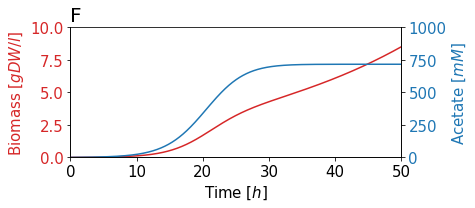

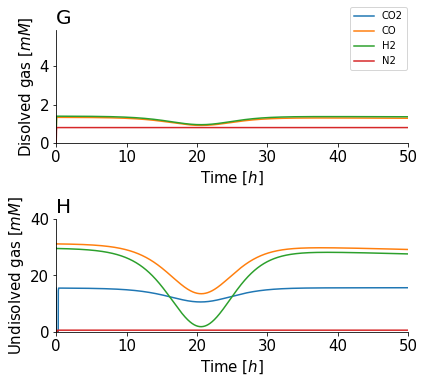

In [15]:
fig, ax1 = plt.subplots(figsize=(6.5,3))

plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = False
if sim == 1: plt.title("C", fontdict = {'fontsize': 20}, loc = "left")
elif sim == 2: plt.title("F", fontdict = {'fontsize': 20}, loc = "left")
else: plt.title(f"Acetogenic Growth Simulation in Bubble Column at {Tc}°C")
color = 'tab:red'
ax1.set_xlabel(r'Time [$h$]', fontsize=15)
ax1.set_ylabel(r'Biomass [$gDW/l$]', color=color, fontsize=15)
ax1.plot(t, (z[:,0]+z[:,1])*24.6/1000, color=color) #Sum of carboxydotrophic and homoacetogenic, converted to gDW assuming C1 H1.8 O0.5 N0.2
ax1.axis([0, t_rt, 0, 10])
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='both', which='major', labelsize=15)

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'Acetate [$mM$]', color=color, fontsize=15)  # we already handled the x-label with ax1
ax2.plot(t, z[:,2], color=color)
ax2.axis([0, t_rt, 0, 1000])
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams['axes.spines.top'] = False

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.show()

fig = plt.figure(figsize=(6,5.4))

plt.rcParams['axes.spines.right'] = False
#plt.rcParams['axes.spines.top'] = False
plt.subplot(2,1,1)
if sim == 1: plt.title("D", fontdict = {'fontsize': 20}, loc = "left")
elif sim == 2: plt.title("G", fontdict = {'fontsize': 20}, loc = "left")
else: plt.title("")
plt.plot(t,z[:,3])
plt.plot(t,z[:,4])
plt.plot(t,z[:,5])
plt.plot(t,z[:,6])
plt.xlabel(r'Time [$h$]', fontsize=15)
plt.ylabel(r'Disolved gas [$mM$]', fontsize=15)
plt.axis([0, t_rt, 0, 5.9])
plt.tick_params(axis='both', which='major', labelsize=15)
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
if sim == 2: plt.legend(['CO2','CO',"H2","N2"],bbox_to_anchor=(0.82, 0.6))

plt.subplot(2,1,2)
if sim == 1: plt.title("E", fontdict = {'fontsize': 20}, loc = "left")
elif sim == 2: plt.title("H", fontdict = {'fontsize': 20}, loc = "left")
else: plt.title("")
plt.plot(t,z[:,7])
plt.plot(t,z[:,8])
plt.plot(t,z[:,9])
plt.plot(t,z[:,10])
plt.xlabel(r'Time [$h$]', fontsize=15)
plt.ylabel(r'Undisolved gas [$mM$]', fontsize=15)
plt.axis([0, t_rt, 0, 40])
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.rcParams['axes.spines.right'] = False
#plt.rcParams['axes.spines.top'] = False
#plt.legend(['CO2','CO',"H2","N2"])
fig.tight_layout()